In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/SMAI/Assignment3/
!pwd

Mounted at /content/drive
/content/drive/.shortcut-targets-by-id/11xtOGD7-mss1uRsA8RtKo1lxZCPV17kx/SMAI/Assignment3
/content/drive/.shortcut-targets-by-id/11xtOGD7-mss1uRsA8RtKo1lxZCPV17kx/SMAI/Assignment3


In [ ]:
import torch
import torch.nn as nn
import torchvision
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imat
import torch.nn as nn
import torch.nn.functional as F
from torchvision.datasets import MNIST
from torchvision.transforms import *
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.optim.lr_scheduler import StepLR
from torchvision.utils import save_image
import os
import time
import gc
import shutil
import h5py
from sklearn.decomposition import PCA
%matplotlib inline

# **PART 1**

In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
     transforms.Normalize((0.5), (0.5))])
os.makedirs("data/mnist", exist_ok=True)
train_dataset = MNIST(root='data/mnist', train=True, download=True, transform=transform)
test_dataset = MNIST(root='data/mnist', train=False, transform=transform)
print(len(train_dataset), len(test_dataset))

# whole_dataset = ConcatDataset([train_dataset, test_dataset])
# print(len(whole_dataset))

# train_size = int(len(whole_dataset)*0.7)
# test_size = int(len(whole_dataset)*0.3)

# print(train_size, test_size)

# train_dataset, test_dataset = torch.utils.data.random_split(whole_dataset, [train_size, test_size])
# print(len(train_dataset), len(test_dataset))

60000 10000


### Utility functions

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def save_checkpoint(state, is_best, epoch, name):
    filename = 'q2_checkpoints/q2_ckpt_'+name
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, filename+'_best')

def test_model(model_class, ckpt):
    model = model_class().cuda()
    # print(model)
    checkpoint = torch.load('q2_checkpoints/'+ckpt)
    model.load_state_dict(checkpoint['model_state_dict'])
    test_loader = DataLoader(test_dataset, 1, num_workers=2, pin_memory=True)  
    criterion = nn.MSELoss().cuda()  
    losses = 0
    fig, axs = plt.subplots(2, 10, figsize=(20,4))
    model.eval()        
    for i, (inputs, _) in enumerate(test_loader):
        inputs = inputs.to(device)
        inputs = torch.flatten(inputs, start_dim=1)
        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, inputs)
            losses += loss.detach().cpu().item()
            if i < 10:
                axs[0,i].imshow(inputs[0].reshape((28,28)).cpu().numpy())
                axs[0,i].axis('off')
                axs[1,i].imshow(outputs[0].reshape((28,28)).cpu().numpy())
                axs[1,i].axis('off')
                # plt.subplot(2, 10, i+1)
                # plt.imshow(inputs[0].reshape((28,28)).cpu().numpy())
                # plt.subplot(2, 10, 10+i+1)
                # plt.imshow(outputs[0].reshape((28,28)).cpu().numpy())
            # else:
            #     break
        torch.cuda.empty_cache()
        gc.collect()
    return losses/len(test_loader)

def plot_train(losses):
    plt.plot(range(len(losses)), losses, label = "Train loss", color='blue')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Train loss')
    plt.legend()
    plt.show()

def show_train_imgs(img_name, epochs):
    row_imgs = epochs//5+1
    fig, axs = plt.subplots(1, row_imgs, figsize=(20,20))
    for i in range(0,epochs):
        if i%5==0:
            img = imat.imread('q2_images/'+img_name+'_'+str(i)+'.png')
            axs[i//5].imshow(img)
            axs[i//5].set_title('Epoch '+str(i))
            axs[i//5].axis('off')
        elif i==epochs-1:
            img = imat.imread('q2_images/'+img_name+'_'+str(i)+'.png')
            axs[i//5+1].imshow(img)
            axs[i//5+1].set_title('Epoch '+str(i))
            axs[i//5+1].axis('off')
        else:
            continue

### AutoEncoder trainer class

In [ ]:
class AE_Trainer(object):
    def __init__(self, device, model_class, ckpt_name, load_ckpt=None, epochs=10, batch_size=64, lr=0.1, optm='sgd', mom=0.9, lr_decay=None, step=4, weight_decay=0, trainset=train_dataset):
        self.device = device
        self.lr =  lr
        self.step_size = step
        self.momentum = mom
        self.lr_decay = lr_decay
        self.weight_decay = weight_decay
        self.batch_size = batch_size
        self.start_epoch = 0
        self.epochs = epochs
        self.workers = 2
        self.seed = int(time.time())
        self.checkpoint_path = load_ckpt 
        self.best_error = 1e8
        self.best_epoch = 0
        self.ckpt_name = ckpt_name
        self.loss_history = []
        self.trainset = trainset
        torch.cuda.manual_seed(self.seed)
        print(self.device,torch.cuda.get_device_name(0))

        self.model = model_class().cuda()
        # print(self.model)
        if optm=='sgd':
            self.optimizer = torch.optim.SGD(self.model.parameters(), self.lr, momentum=self.momentum, weight_decay=self.weight_decay)
        elif optm=='adam':
            self.optimizer = torch.optim.Adam(self.model.parameters(), self.lr)
        elif optm=='rms':
            self.optimizer = torch.optim.RMSprop(self.model.parameters(), self.lr, momentum=self.momentum)
        self.criterion = nn.MSELoss().cuda()
        self.scheduler = StepLR(self.optimizer, step_size=self.step_size, gamma=self.lr_decay)
        
        if self.checkpoint_path:
            checkpoint = torch.load(self.checkpoint_path)
            self.model.load_state_dict(checkpoint['model_state_dict'])
            self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
            self.start_epoch = checkpoint['epoch']+1
            loss = checkpoint['loss']
            self.best_error = checkpoint['best_error']
            self.best_epoch = checkpoint['best_epoch']
        
    def train(self):
        for epoch in range(self.start_epoch, self.epochs):
            error = self.train_epoch(epoch)
            if error < self.best_error:
                is_best = True
                self.best_epoch = epoch
            else:
                is_best = False
            self.loss_history.append(error)
            self.best_error = min(error, self.best_error)
            print('Epoch:'+str(epoch),'  Loss:'+str(round(error,3)))
            save_checkpoint({
                'epoch': epoch,
                'model_state_dict': self.model.state_dict(),
                'optimizer_state_dict': self.optimizer.state_dict(),
                'loss': error,
                'best_error': self.best_error,
                'best_epoch': self.best_epoch
            }, is_best, epoch, self.ckpt_name)
            self.scheduler.step()
        return self.best_epoch, self.best_error, self.loss_history

    def train_epoch(self, cur_epoch):
        train_loader = DataLoader(self.trainset, self.batch_size, shuffle=True, num_workers=self.workers, pin_memory=True)        
        self.model.train()        
        losses = 0
        out_imgs = None
        for i, (inputs, _) in enumerate(train_loader):
            inputs = inputs.to(self.device)
            inputs = torch.flatten(inputs, start_dim=1)
            with torch.set_grad_enabled(True):
                outputs = self.model(inputs)
                loss = self.criterion(outputs, inputs)
                losses += loss.detach().cpu().item()
                self.optimizer.zero_grad()
                loss.backward()
                self.optimizer.step()
                if i == len(train_loader)-2:
                    out_imgs = outputs.data[:25].reshape((25,1,28,28))
                    save_image(out_imgs, "q2_images/"+self.ckpt_name+"_%d.png" % cur_epoch, nrow=5, normalize=True)
            torch.cuda.empty_cache()
            gc.collect()

        return losses/len(train_loader)

# 1) AutoEncoder with 128 hidden neurons

In [ ]:
class AutoEncoder_128(nn.Module):
    def __init__(self):
        super(AutoEncoder_128, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 128), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(128, 64), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 32), #output
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 128), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(128, 784), #output
            nn.Tanh()
        )

    def forward(self,x):
        x = self.encoder(x)
        # print('after conv',x.shape)
        x = self.decoder(x)
        return x

### SGD without momentum (128-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.905
Epoch:1   Loss:0.552
Epoch:2   Loss:0.278
Epoch:3   Loss:0.272
Epoch:4   Loss:0.269
Epoch:5   Loss:0.268
Epoch:6   Loss:0.267
Epoch:7   Loss:0.267
Epoch:8   Loss:0.266
Epoch:9   Loss:0.265


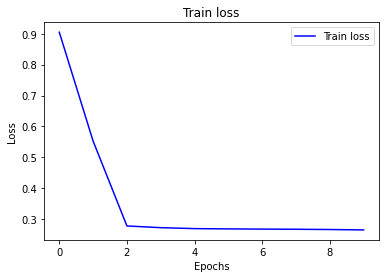

Best epoch: 9


In [ ]:
aea_trainer = AE_Trainer(device, AutoEncoder_128, 'AE_a', lr=0.01, epochs=10, lr_decay=0.9, step=1, mom=0)
a_best_epoch, a_best_error, a_losses = aea_trainer.train()
plot_train(a_losses)
print('Best epoch:',a_best_epoch)

Images reconstructed during train


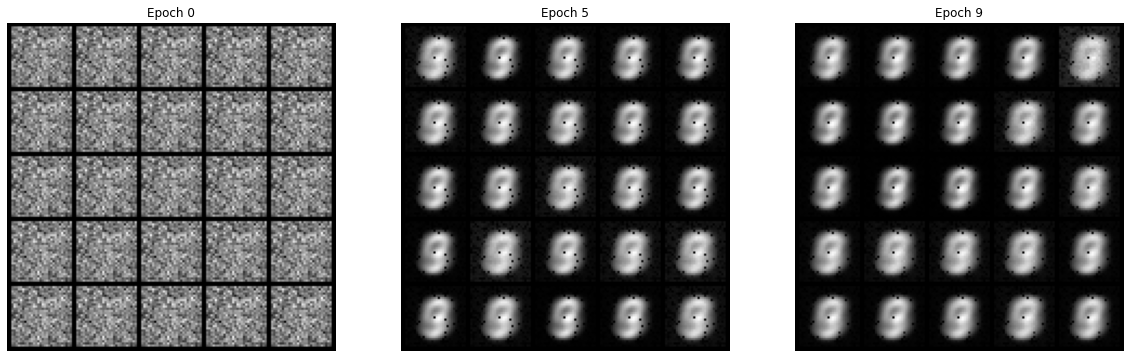

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_a', 10)

Test MSE loss: 0.2655115610204637


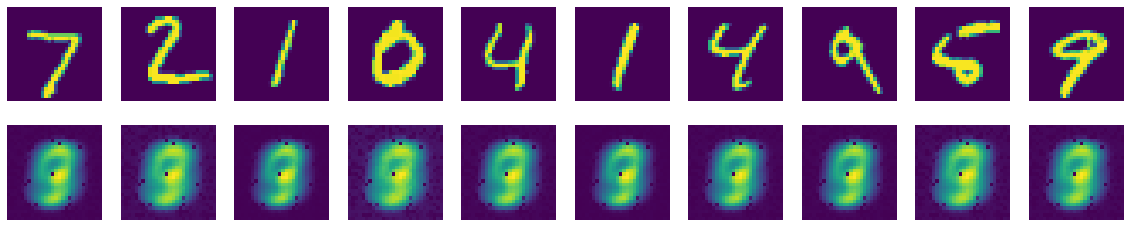

In [ ]:
a_test_loss = test_model(AutoEncoder_128, 'q2_ckpt_AE_a_best')
print('Test MSE loss:',a_test_loss)

### SGD with momentum (128-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.404
Epoch:1   Loss:0.255
Epoch:2   Loss:0.241
Epoch:3   Loss:0.227
Epoch:4   Loss:0.21
Epoch:5   Loss:0.19
Epoch:6   Loss:0.173
Epoch:7   Loss:0.16
Epoch:8   Loss:0.155
Epoch:9   Loss:0.15


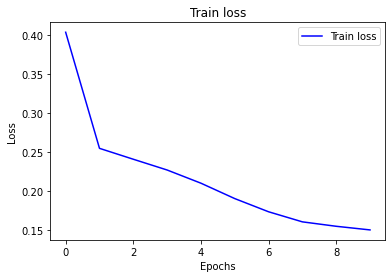

Best epoch: 9


In [ ]:
aeb_trainer = AE_Trainer(device, AutoEncoder_128, 'AE_b', lr=0.01, epochs=10, lr_decay=0.9, step=4, mom=0.9)
b_best_epoch, b_best_error, b_losses = aeb_trainer.train()
plot_train(b_losses)
print('Best epoch:',b_best_epoch)

Images reconstructed during train


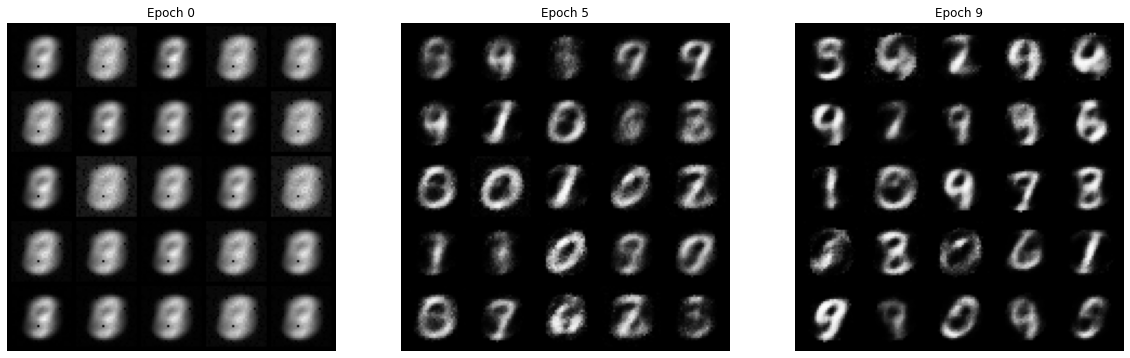

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_b', 10)

Test MSE loss: 0.14523896474093198


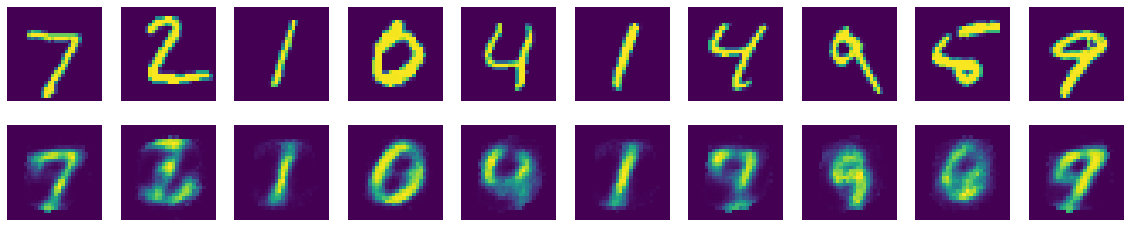

In [ ]:
b_test_loss = test_model(AutoEncoder_128, 'q2_ckpt_AE_b_best')
print('Test MSE loss:',b_test_loss)

### ADAM optimizer (128-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.14
Epoch:1   Loss:0.07
Epoch:2   Loss:0.057
Epoch:3   Loss:0.049
Epoch:4   Loss:0.044
Epoch:5   Loss:0.04
Epoch:6   Loss:0.038
Epoch:7   Loss:0.036
Epoch:8   Loss:0.034
Epoch:9   Loss:0.033


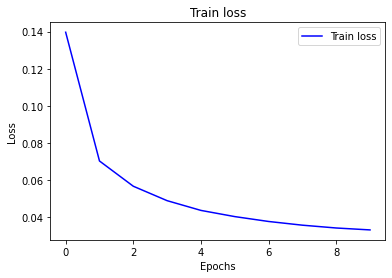

Best epoch: 9


In [ ]:
aec_trainer = AE_Trainer(device, AutoEncoder_128, 'AE_c', epochs=10, lr=0.001, optm='adam', lr_decay=0.95, step=4, mom=0.9)
c_best_epoch, c_best_error, c_losses = aec_trainer.train()
plot_train(c_losses)
print('Best epoch:',c_best_epoch)

Images reconstructed during train


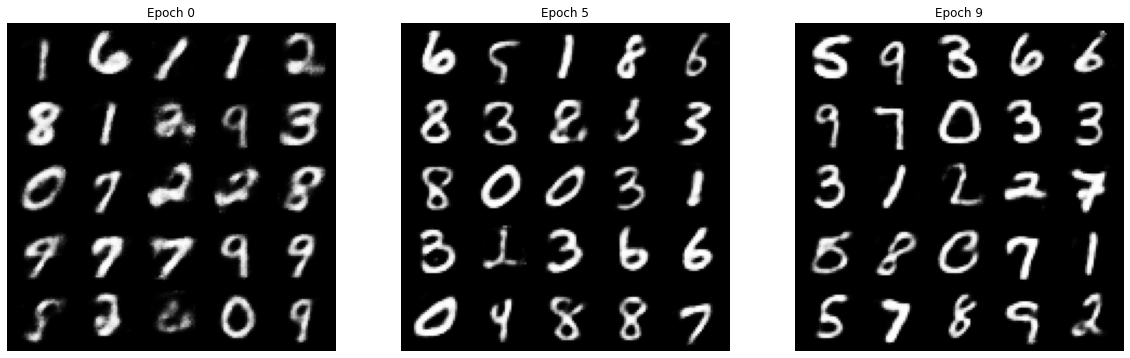

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_c', 10)

Test MSE loss: 0.032505914707039486


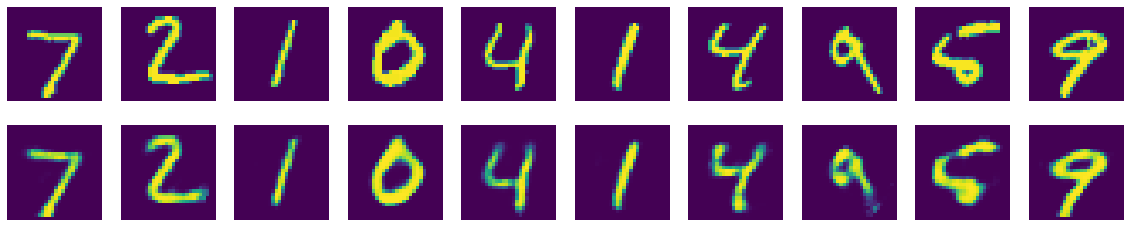

In [ ]:
c_test_loss = test_model(AutoEncoder_128, 'q2_ckpt_AE_c_best')
print('Test MSE loss:',c_test_loss)

### RMSProp optimizer (128-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.147
Epoch:1   Loss:0.077
Epoch:2   Loss:0.062
Epoch:3   Loss:0.053
Epoch:4   Loss:0.047
Epoch:5   Loss:0.043
Epoch:6   Loss:0.04
Epoch:7   Loss:0.038
Epoch:8   Loss:0.035
Epoch:9   Loss:0.034


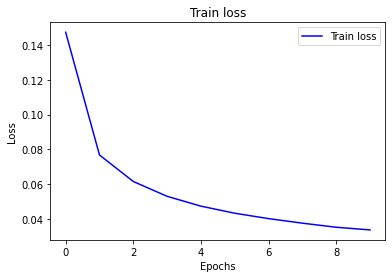

Best epoch: 9


In [ ]:
aed_trainer = AE_Trainer(device, AutoEncoder_128, 'AE_d', epochs=10, lr=0.0001, optm='rms', lr_decay=0.9, step=4, mom=0.9)
d_best_epoch, d_best_error, d_losses = aed_trainer.train()
plot_train(d_losses)
print('Best epoch:',d_best_epoch)

Images reconstructed during train


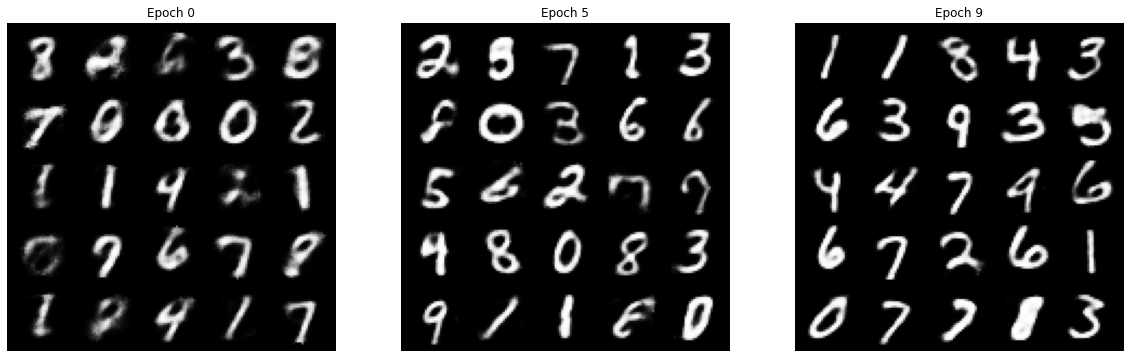

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_d', 10)

Test MSE loss: 0.03231631144483108


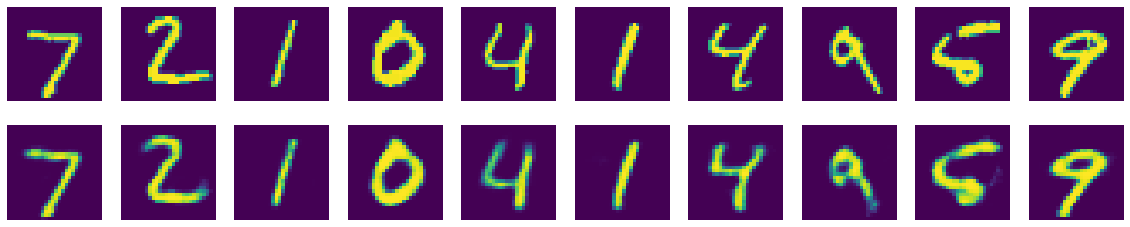

In [ ]:
d_test_loss = test_model(AutoEncoder_128, 'q2_ckpt_AE_d_best')
print('Test MSE loss:',d_test_loss)

# AutoEncoder with 256 hidden neurons

In [ ]:
class AutoEncoder_256(nn.Module):
    def __init__(self):
        super(AutoEncoder_256, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(256, 64), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 32), #output
        )
        self.decoder = nn.Sequential(
            nn.Linear(32, 64), #input
            nn.LeakyReLU(inplace=True), 
            nn.Linear(64, 256), #hidden
            nn.ReLU(inplace=True), 
            nn.Linear(256, 784), #output
            nn.Tanh()
        )

    def forward(self,x):
        x = self.encoder(x)
        # print('after conv',x.shape)
        x = self.decoder(x)
        return x

### SGD without momentum (256-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.787
Epoch:1   Loss:0.272
Epoch:2   Loss:0.267
Epoch:3   Loss:0.265
Epoch:4   Loss:0.265
Epoch:5   Loss:0.264
Epoch:6   Loss:0.263
Epoch:7   Loss:0.263
Epoch:8   Loss:0.262
Epoch:9   Loss:0.262


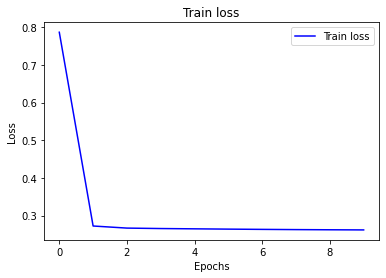

Best epoch: 9


In [ ]:
aep_trainer = AE_Trainer(device, AutoEncoder_256, 'AE_p', lr=0.01, epochs=10, lr_decay=0.9, step=1, mom=0)
p_best_epoch, p_best_error, p_losses = aep_trainer.train()
plot_train(p_losses)
print('Best epoch:',p_best_epoch)

Images reconstructed during train


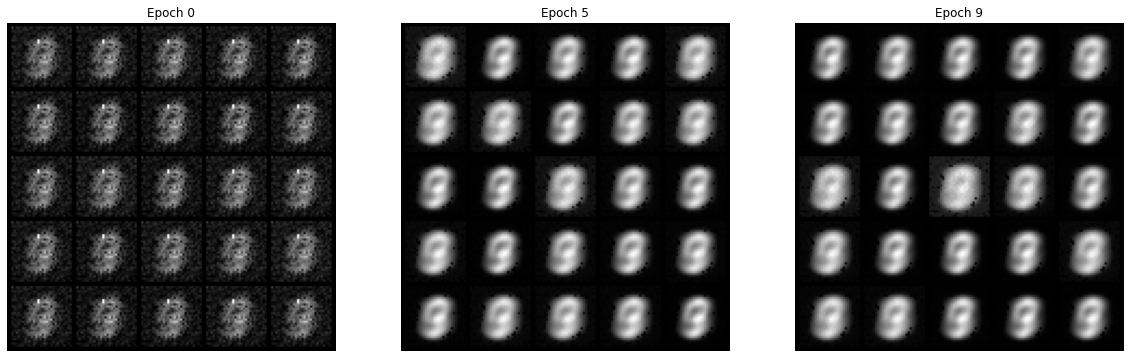

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_p', 10)

Test MSE loss: 0.2625294291757047


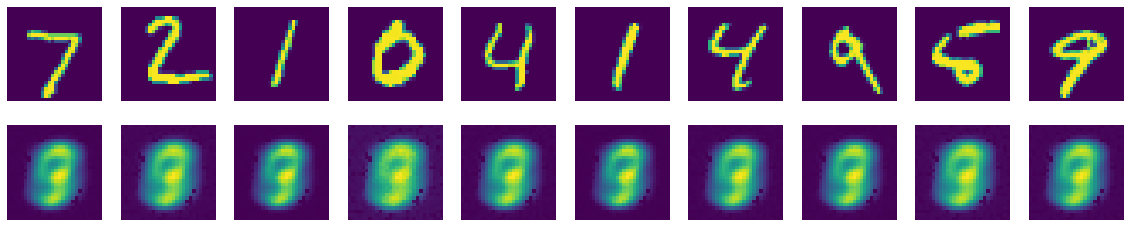

In [ ]:
p_test_loss = test_model(AutoEncoder_256, 'q2_ckpt_AE_p_best')
print('Test MSE loss:',p_test_loss)

### SGD with momentum (256-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.338
Epoch:1   Loss:0.258
Epoch:2   Loss:0.249
Epoch:3   Loss:0.23
Epoch:4   Loss:0.212
Epoch:5   Loss:0.194
Epoch:6   Loss:0.175
Epoch:7   Loss:0.165
Epoch:8   Loss:0.159
Epoch:9   Loss:0.153


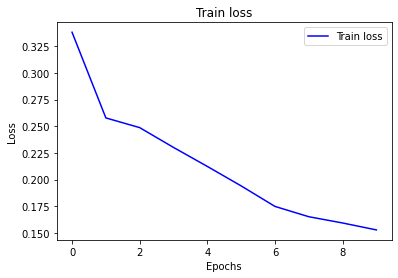

Best epoch: 9


In [ ]:
aeq_trainer = AE_Trainer(device, AutoEncoder_256, 'AE_q', lr=0.01, epochs=10, lr_decay=0.9, step=4, mom=0.9)
q_best_epoch, q_best_error, q_losses = aeq_trainer.train()
plot_train(q_losses)
print('Best epoch:',q_best_epoch)

Images reconstructed during train


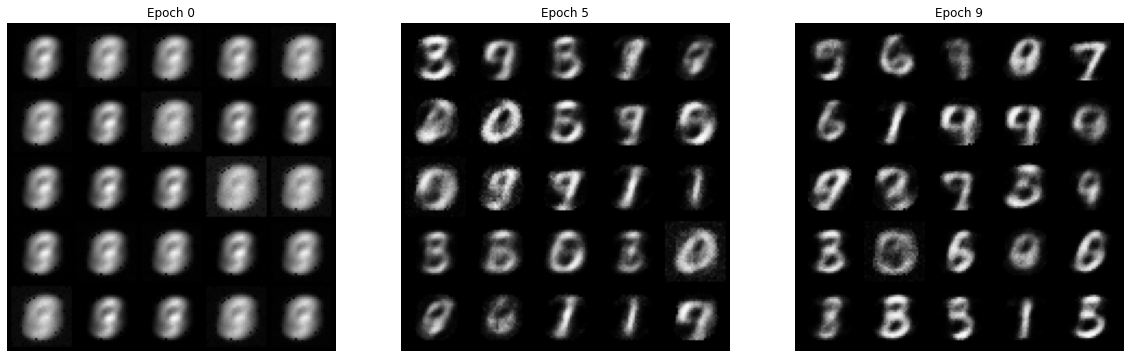

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_q', 10)

Test MSE loss: 0.14740822667293252


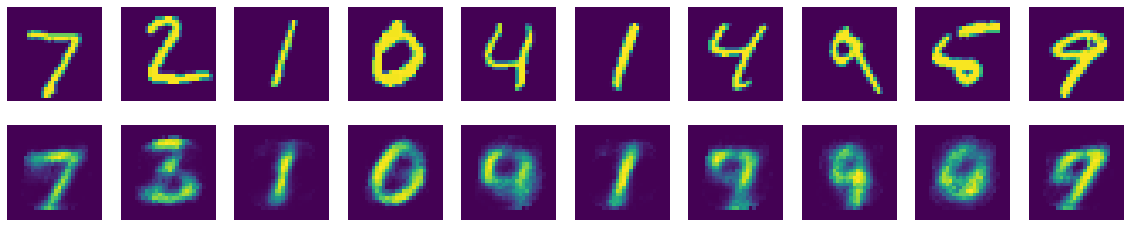

In [ ]:
q_test_loss = test_model(AutoEncoder_256, 'q2_ckpt_AE_q_best')
print('Test MSE loss:',q_test_loss)

### ADAM optimizer (256-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.117
Epoch:1   Loss:0.058
Epoch:2   Loss:0.046
Epoch:3   Loss:0.04
Epoch:4   Loss:0.036
Epoch:5   Loss:0.033
Epoch:6   Loss:0.031
Epoch:7   Loss:0.03
Epoch:8   Loss:0.028
Epoch:9   Loss:0.027


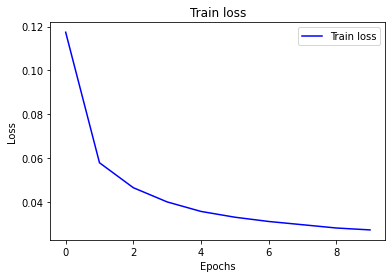

Best epoch: 9


In [ ]:
aer_trainer = AE_Trainer(device, AutoEncoder_256, 'AE_r', epochs=10, lr=0.001, optm='adam', lr_decay=0.9, step=4, mom=0.9)
r_best_epoch, r_best_error, r_losses = aer_trainer.train()
plot_train(r_losses)
print('Best epoch:',r_best_epoch)

Images reconstructed during train


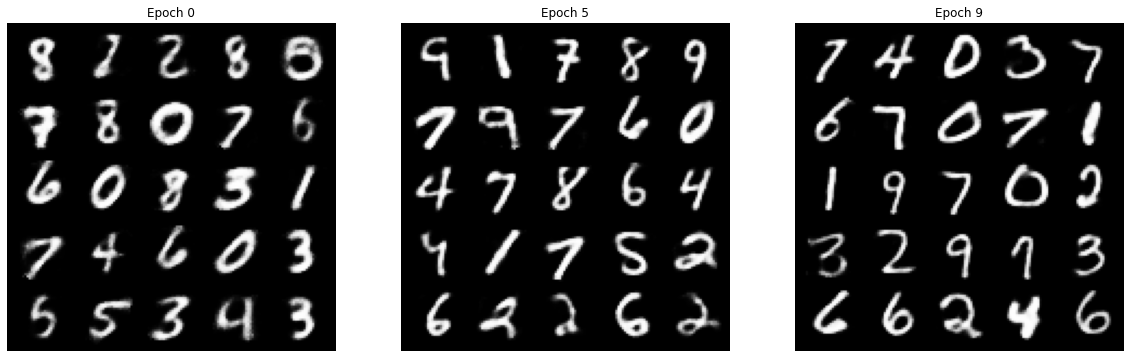

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_r', 10)

Test MSE loss: 0.02673023910499178


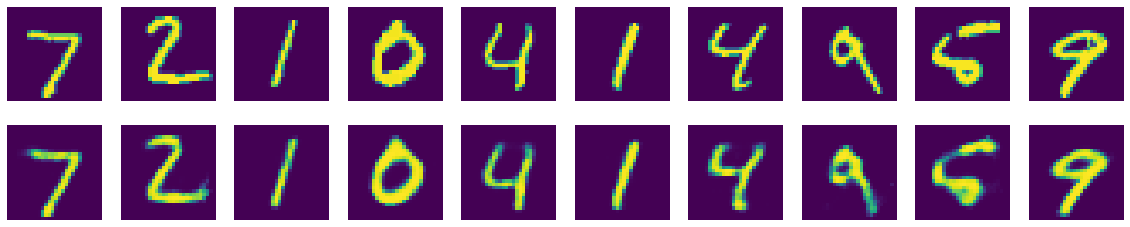

In [ ]:
r_test_loss = test_model(AutoEncoder_256, 'q2_ckpt_AE_r_best')
print('Test MSE loss:',r_test_loss)

### RMSProp optimizer (256-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.148
Epoch:1   Loss:0.067
Epoch:2   Loss:0.053
Epoch:3   Loss:0.045
Epoch:4   Loss:0.04
Epoch:5   Loss:0.037
Epoch:6   Loss:0.035
Epoch:7   Loss:0.033
Epoch:8   Loss:0.031
Epoch:9   Loss:0.03


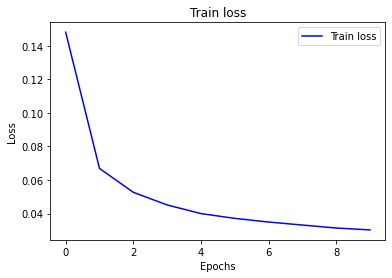

Best epoch: 9


In [ ]:
aes_trainer = AE_Trainer(device, AutoEncoder_256, 'AE_s', epochs=10, lr=0.0001, optm='rms', lr_decay=0.9, step=4, mom=0.9)
s_best_epoch, s_best_error, s_losses = aes_trainer.train()
plot_train(s_losses)
print('Best epoch:',s_best_epoch)

Images reconstructed during train


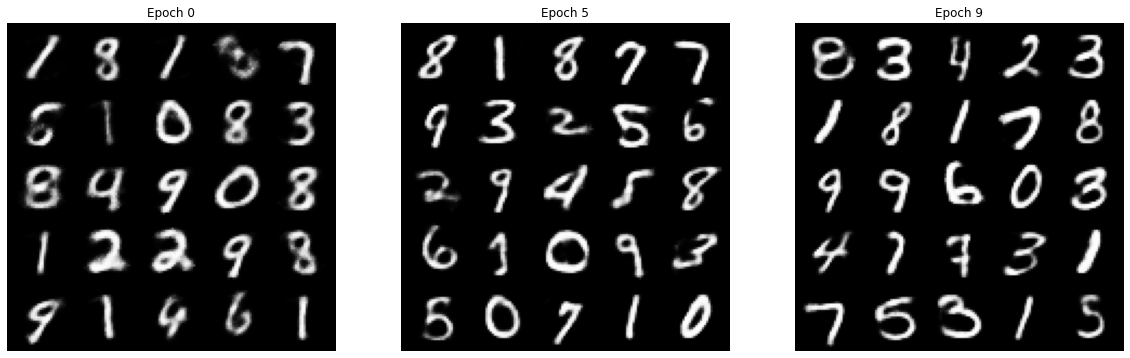

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_s', 10)

Test MSE loss: 0.02977983147293562


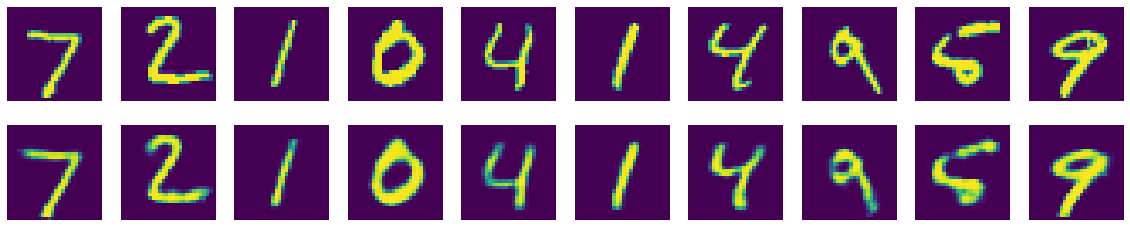

In [ ]:
s_test_loss = test_model(AutoEncoder_256, 'q2_ckpt_AE_s_best')
print('Test MSE loss:',s_test_loss)

# AutoEncoder with 512 hidden neurons

In [ ]:
class AutoEncoder_512(nn.Module):
    def __init__(self):
        super(AutoEncoder_512, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 512), #input
            nn.LeakyReLU(inplace=True), 
            nn.Dropout(0.2),
            nn.Linear(512, 128), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(128, 64), #output
        )
        self.decoder = nn.Sequential(
            nn.Linear(64, 128), #input
            nn.LeakyReLU(inplace=True), 
            nn.Dropout(0.2),
            nn.Linear(128, 512), #hidden
            nn.LeakyReLU(inplace=True), 
            nn.Linear(512, 784), #output
            nn.Tanh()
        )

    def forward(self,x):
        x = self.encoder(x)
        # print('after conv',x.shape)
        x = self.decoder(x)
        return x

### SGD without momentum (512-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.768
Epoch:1   Loss:0.269
Epoch:2   Loss:0.265
Epoch:3   Loss:0.264
Epoch:4   Loss:0.263
Epoch:5   Loss:0.263
Epoch:6   Loss:0.262
Epoch:7   Loss:0.262
Epoch:8   Loss:0.261
Epoch:9   Loss:0.261


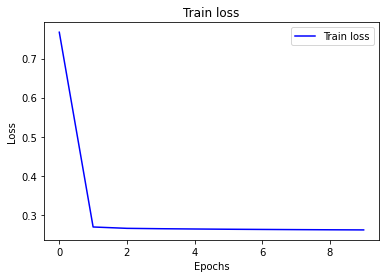

Best epoch: 9


In [ ]:
aew_trainer = AE_Trainer(device, AutoEncoder_512, 'AE_w', lr=0.01, epochs=10, lr_decay=0.9, step=1, mom=0)
w_best_epoch, w_best_error, w_losses = aew_trainer.train()
plot_train(w_losses)
print('Best epoch:',w_best_epoch)

Images reconstructed during train


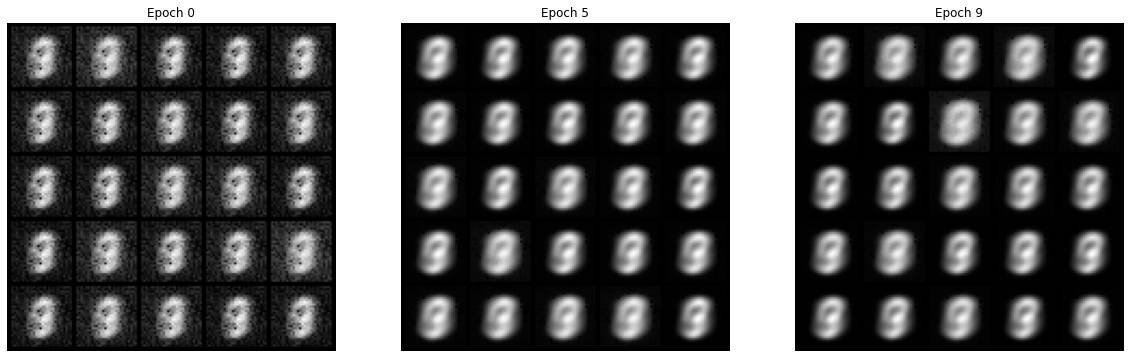

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_w', 10)

Test MSE loss: 0.26186314888224005


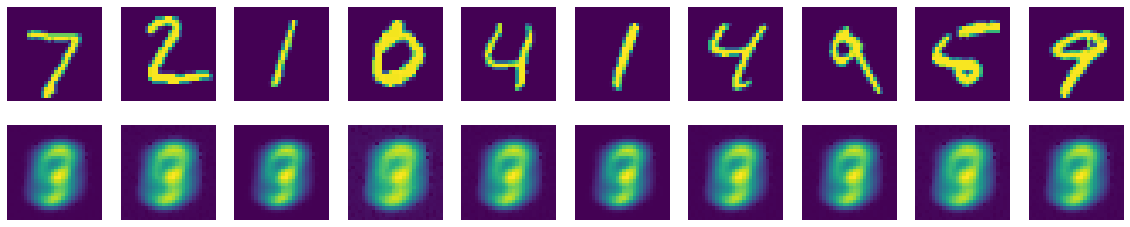

In [ ]:
w_test_loss = test_model(AutoEncoder_512, 'q2_ckpt_AE_w_best')
print('Test MSE loss:',w_test_loss)

### SGD with momentum (512-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.333
Epoch:1   Loss:0.254
Epoch:2   Loss:0.232
Epoch:3   Loss:0.197
Epoch:4   Loss:0.171
Epoch:5   Loss:0.161
Epoch:6   Loss:0.148
Epoch:7   Loss:0.136
Epoch:8   Loss:0.126
Epoch:9   Loss:0.119


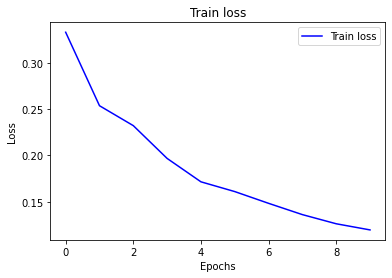

Best epoch: 9


In [ ]:
aex_trainer = AE_Trainer(device, AutoEncoder_512, 'AE_x', lr=0.01, epochs=10, lr_decay=0.9, step=4, mom=0.9)
x_best_epoch, x_best_error, x_losses = aex_trainer.train()
plot_train(x_losses)
print('Best epoch:',x_best_epoch)

Images reconstructed during train


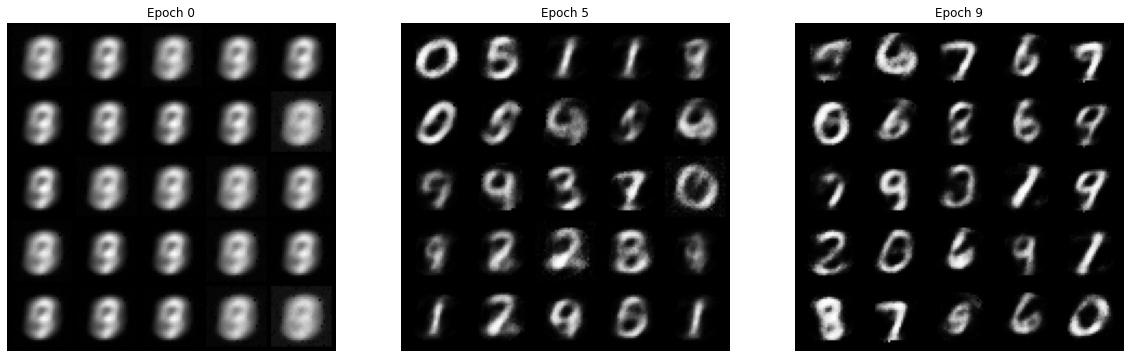

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_x', 10)

Test MSE loss: 0.11446321044992655


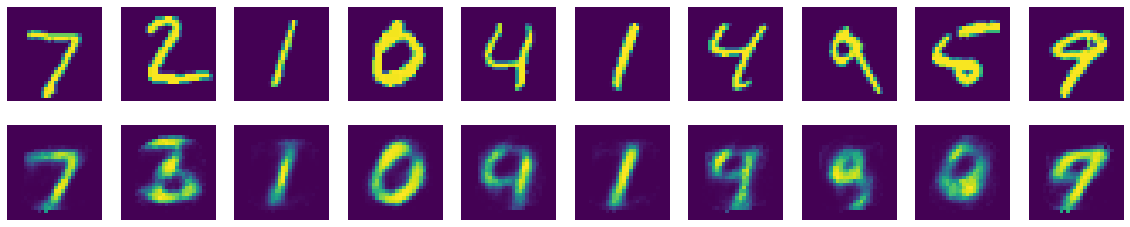

In [ ]:
x_test_loss = test_model(AutoEncoder_512, 'q2_ckpt_AE_x_best')
print('Test MSE loss:',x_test_loss)

### ADAM optimizer (512-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.128
Epoch:1   Loss:0.079
Epoch:2   Loss:0.071
Epoch:3   Loss:0.066
Epoch:4   Loss:0.063
Epoch:5   Loss:0.061
Epoch:6   Loss:0.059
Epoch:7   Loss:0.058
Epoch:8   Loss:0.056
Epoch:9   Loss:0.055


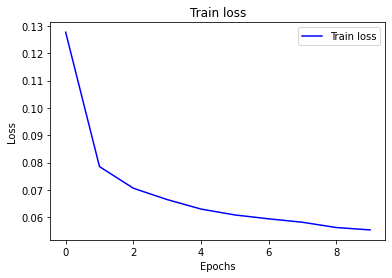

Best epoch: 9


In [ ]:
aey_trainer = AE_Trainer(device, AutoEncoder_512, 'AE_y', epochs=10, lr=0.001, optm='adam', lr_decay=0.9, step=4, mom=0.9)
y_best_epoch, y_best_error, y_losses = aey_trainer.train()
plot_train(y_losses)
print('Best epoch:',y_best_epoch)

Images reconstructed during train


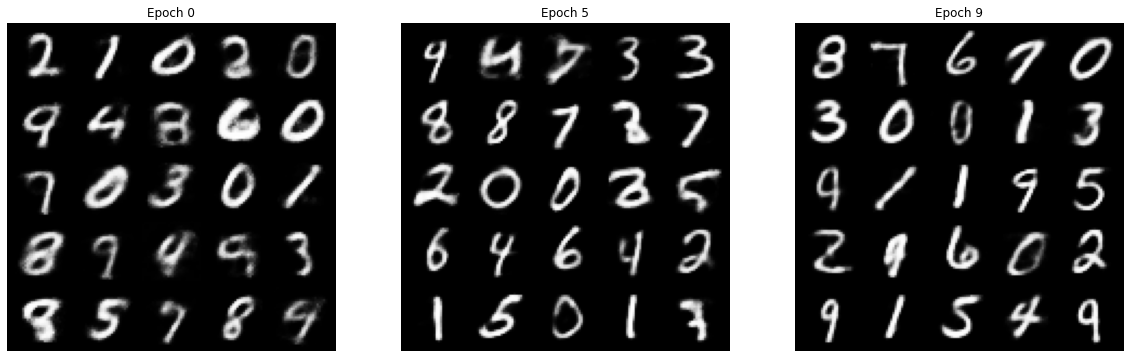

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_y', 10)

Test MSE loss: 0.04011871594134718


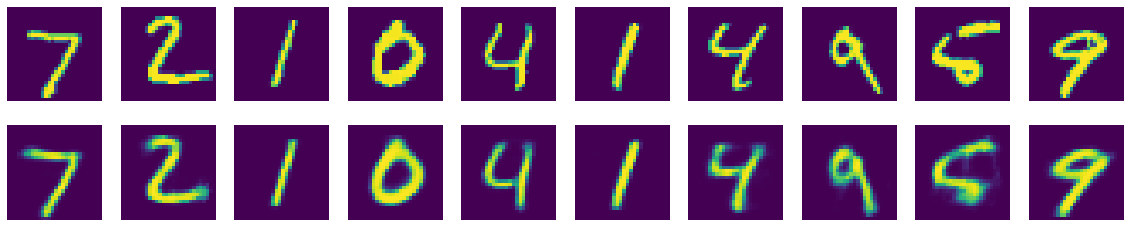

In [ ]:
y_test_loss = test_model(AutoEncoder_512, 'q2_ckpt_AE_y_best')
print('Test MSE loss:',y_test_loss)

### RMSProp optimizer (512-neuron AE)

cuda Tesla T4
Epoch:0   Loss:0.493
Epoch:1   Loss:0.492
Epoch:2   Loss:0.243
Epoch:3   Loss:0.077
Epoch:4   Loss:0.053
Epoch:5   Loss:0.043
Epoch:6   Loss:0.037
Epoch:7   Loss:0.033
Epoch:8   Loss:0.03
Epoch:9   Loss:0.028


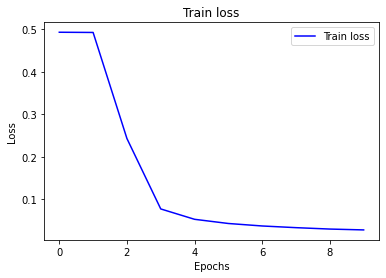

Best epoch: 9


In [ ]:
aez_trainer = AE_Trainer(device, AutoEncoder_512, 'AE_z', epochs=10, lr=0.0001, optm='rms', lr_decay=0.9, step=4, mom=0.9)
z_best_epoch, z_best_error, z_losses = aez_trainer.train()
plot_train(z_losses)
print('Best epoch:',z_best_epoch)

Images reconstructed during train


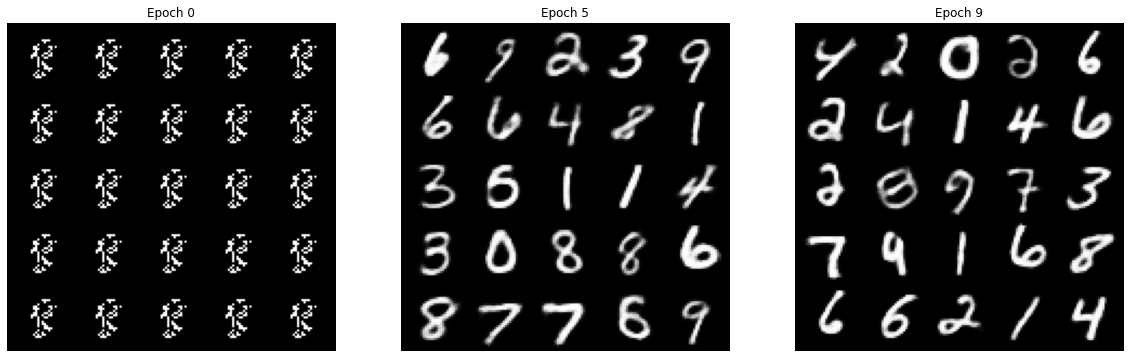

In [ ]:
print('Images reconstructed during train')
show_train_imgs('AE_z', 10)

Test MSE loss: 0.027006355669675394


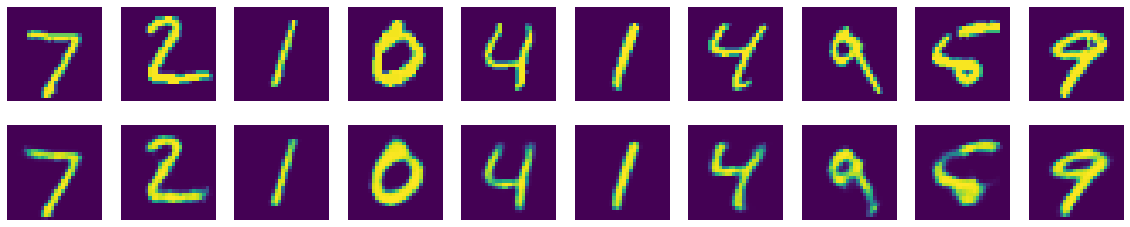

In [ ]:
z_test_loss = test_model(AutoEncoder_512, 'q2_ckpt_AE_z_best')
print('Test MSE loss:',z_test_loss)

--------------------------------------------------------------------------------
# Comparision

In [ ]:
#ae 128 sgd
a_test_loss = 0.26684
#ae 128 sgdm
b_test_loss = 0.13966
#ae 128 adam
c_test_loss = 0.05103
#ae 128 rms
d_test_loss = 0.04923

#ae 256 sgd
p_test_loss = 0.26664
#ae 256 sgdm
q_test_loss = 0.12252
#ae 256 adam
r_test_loss = 0.03852
#ae 256 rms
s_test_loss = 0.0374

#ae 512 sgd
w_test_loss = 0.26593
#ae 512 sgdm
x_test_loss = 0.09686
#ae 512 adam
y_test_loss = 0.02038
#ae 512 rms
z_test_loss = 0.02039

In [ ]:
neurons = [128, 256, 512]
sgd = [a_test_loss, p_test_loss, w_test_loss]
sgdm = [b_test_loss, q_test_loss, x_test_loss]
adam = [c_test_loss, r_test_loss, y_test_loss]
rms = [d_test_loss, s_test_loss, z_test_loss]

plt.plot(neurons, sgd, label = "SGD loss", color='blue', markersize=5, marker='o',markerfacecolor='blue')
plt.xlabel('No. of hidden neurons')
plt.ylabel('Reconstruction loss')
plt.title('Hidden neurons vs reconstruction loss')
plt.legend()
plt.show()

plt.plot(neurons, sgdm, label = "SGD-M loss", color='red', markersize=5, marker='o',markerfacecolor='red')
plt.xlabel('No. of hidden neurons')
plt.ylabel('Reconstruction loss')
plt.title('Hidden neurons vs reconstruction loss')
plt.legend()
plt.show()

plt.plot(neurons, adam, label = "ADAM loss", color='green', markersize=5, marker='o',markerfacecolor='green')
plt.xlabel('No. of hidden neurons')
plt.ylabel('Reconstruction loss')
plt.title('Hidden neurons vs reconstruction loss')
plt.legend()
plt.show()

plt.plot(neurons, rms, label = "RMSP loss", color='magenta', markersize=5, marker='o',markerfacecolor='magenta')
plt.xlabel('No. of hidden neurons')
plt.ylabel('Reconstruction loss')
plt.title('Hidden neurons vs reconstruction loss')
plt.legend()
plt.show()

### Part1 Conclusion:  


*   As the number of neurons increases, the reconstruction loss decreases, as the model learns more features
*   SGD without momentum gets stuck in the local minima and thus learning stagnates at higher loss. Momentum helps SGD escape from the local minima
*   ADAM and RMSProp are better than SGD and are comparable in performance




------------------------------------------------------------------------------  
# PART 2

In [ ]:
pca = PCA(128)
train_data_rshp = train_dataset.train_data.flatten(start_dim=1)
test_data_rshp = test_dataset.train_data.flatten(start_dim=1)
pca.fit(train_data_rshp)
pca_testset = pca.transform(test_data_rshp)
pca_reimgs = pca.inverse_transform(pca_testset)
pca_reimgs = torch.from_numpy(pca_reimgs)

fig, axs = plt.subplots(2, 10, figsize=(20,4))
for i in range(0,10):
    org_img = test_data_rshp[i].reshape((28,28))
    pca_img = pca_reimgs[i].reshape((28,28))
    axs[0,i].imshow(org_img)
    axs[0,i].axis('off')
    axs[1,i].imshow(pca_img)
    axs[1,i].axis('off')

In [ ]:
pca_loss = 0
pca_loss += nn.functional.mse_loss(pca_reimgs,test_data_rshp)
pca_loss /= len(test_data_rshp)
print('PCA reconstruction loss:',pca_loss)
print('AutoEncoder reconstruction loss:',y_test_loss)


We can observe that our AutoEncoder is able to beat PCA in reconstructing images. However this may vary with AutoEncoder's hyperparameters and PCA's number of components.